In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import nltk
from nltk.corpus import stopwords
import spacy
from spacy import displacy
from collections import Counter
from wordcloud import WordCloud
import en_core_web_sm
nlp = en_core_web_sm.load()
import warnings
warnings.filterwarnings('ignore')
import requests
import json
import tweepy
from sklearn.cluster import KMeans
from nltk.stem.porter import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding, LSTM
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
import time
import datetime
from textblob import TextBlob

### SKIP to 'Data Cleaning and Exploratory Data Analysis' if you have output csv 

# Data Extraction 

In [2]:
# Twitter Keys : Private
api_key = 'JnXwpkpaLFuf8JbODAOmM7ETZ'
api_secret = 'Cr8NDG0qeOEuD9gBCBGnjwe4LNLTyTn0Cv3bWjQ4GLJscKzSiO'
access_token = '1717988347-fF36xwcT2RGDDFTaEL8yBfZpiIW3Pcho2i9sDWQ'
access_secret = 'XGL0hca8rpEMP1fNVIEMEKZ3DwyiGBZ776hKMZMz9ezAo'
bearer = 'AAAAAAAAAAAAAAAAAAAAAPVVDwEAAAAAS6UIWq6tPi29XkHZ9HcqMIjFtIk%3DMv3aze5nbGAwUAZtVzrLjpl3uiRpv2BMrk6FUqVuvq7Fmf3ITZ'

In [3]:
# Fetching data: authentication, API call
authenticator = tweepy.OAuthHandler(api_key, api_secret)
authenticator.set_access_token(access_token, access_secret)

api = tweepy.API(authenticator, wait_on_rate_limit=True)

query = 'elonmusk -filter:retweets'

tweets = []
for tweet in tweepy.Cursor(api.search_tweets, q= query, lang="en", tweet_mode="extended", count=100).items(50000):
    tweets.append(tweet._json)

Rate limit reached. Sleeping for: 565
Rate limit reached. Sleeping for: 801
Rate limit reached. Sleeping for: 798
Rate limit reached. Sleeping for: 801


In [4]:
# Feeding the extracted data into pandas dataframe
df = pd.DataFrame(columns=['full_text', 'id','date', 'source', 'likes', 'retweets'])
for tweet in tweets:
    dic = {'full_text': tweet['full_text'], 'id': tweet['id'], 'date': tweet['created_at'],'source': tweet['source'], 'likes': tweet['favorite_count'], 'retweets': tweet['retweet_count']}
    df = df.append(dic, ignore_index = True)
df.head()

,full_text,id,date,source,likes,retweets
0,@ZerberGepeda @elonmusk keep dreaming https://...,1520775996861038593,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...",0,0
1,"@ShibInfo @elonmusk ""WOOF""",1520775996521304064,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
2,@chefjoseandres @elonmusk @WCKitchen Would be ...,1520775994742870023,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
3,Hey @elonmusk I will gladly work remotely for ...,1520775994583388161,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
4,@CGasparino @MilkenInstitute @elonmusk @Tesla ...,1520775994000527360,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0


In [5]:
# Saving the dataframe in a local csv
df.to_csv('output.csv', index=False) 

# Data Cleaning and Exploratory Data Analysis

In [264]:
# Loading the local CSV
df = pd.read_csv('output.csv')
df.head()

,full_text,id,date,source,likes,retweets
0,@ZerberGepeda @elonmusk keep dreaming https://...,1520775996861038593,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...",0,0
1,"@ShibInfo @elonmusk ""WOOF""",1520775996521304064,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
2,@chefjoseandres @elonmusk @WCKitchen Would be ...,1520775994742870023,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
3,Hey @elonmusk I will gladly work remotely for ...,1520775994583388161,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0
4,@CGasparino @MilkenInstitute @elonmusk @Tesla ...,1520775994000527360,Sun May 01 14:43:46 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",0,0


In [265]:
# Data Cleaning: removing unnecessary columns, converting string to lower case, removing links from text
df_filtered = df[['id', 'full_text', 'retweets']]
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: x.lower())
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: re.sub(r"http\S+", "", x))

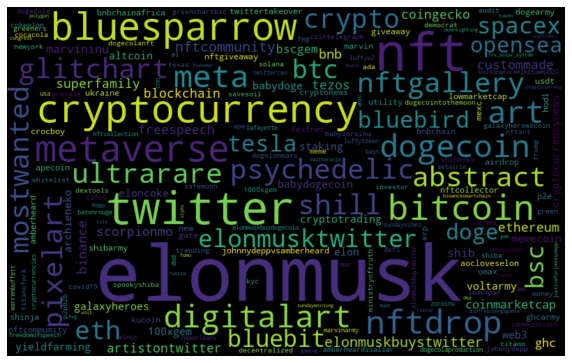

In [266]:
# Extracting hashtags manually

hashtags = df_filtered['full_text'].apply(lambda x: re.findall(r"#(\w+)", x))
hashtags = list(hashtags)
hashtags = [x for x in hashtags if x != []]


# making one string of all hashtags

all_words = ""

for text in hashtags:
    for i in text:
        all_words = all_words + ' ' + i
        

# Making a word cloud of the hashtags to see the most popular words

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)


plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [267]:
def remove_stopwords(text):
    sl = stopwords.words('english')
    w = text.split() 
    clean = " ".join([x for x in w if (x not in sl) and len(x) > 1]) 
    return clean

In [268]:
stemmer = PorterStemmer()
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: remove_stopwords(x)) # removing stopwords
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: re.sub(r'[^A-Za-z\s]','',x)) # removing special characters
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: re.sub("\s+", " ", x)) # removing excess spaces
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: x.split()) # split into word list
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
df_filtered['full_text'] = df_filtered['full_text'].apply(lambda x: ' '.join(x)) # joining the words into sentence
df_filtered.head()

,id,full_text,retweets
0,1520775996861038593,zerbergepeda elonmusk keep dream,0
1,1520775996521304064,shibinfo elonmusk woof,0
2,1520775994742870023,chefjoseandr elonmusk wckitchen would cool acc...,0
3,1520775994583388161,hey elonmusk gladli work remot twitter crybabi...,0
4,1520775994000527360,cgasparino milkeninstitut elonmusk tesla guy p...,0


In [269]:
# Top 10 retweeted tweets
most_retweet = df_filtered[['full_text', 'retweets']].sort_values(by = 'retweets', ascending=False)
most_retweet.head(10)

,full_text,retweets
13549,elonmusk help us wckitchen keep feed ukrain fo...,1057
33040,elonmusk south africa ask buy stock compani re...,352
49478,onlin safeti bill give minist power suppress l...,305
40147,qnt broke buy dip giveaway firstli good even d...,244
19449,elonmusk legend,239
14982,elonmusk pmarca everyon cant stop talk bitcoin,223
27020,first stock stori book r beauti competit stock...,196
27230,elonmusk shibnobi come shinja,145
42294,elonmusk zoro believ peopl need go outdoor hea...,135
43571,hey twitter twittersupport elonmusk constantli...,126


In [270]:
# Most retweeted tweet
print(list(most_retweet.full_text)[0])

elonmusk help us wckitchen keep feed ukrain foodfight like starlink system network hundr restaur feed non stop let go feed world yeswecan


In [271]:
# Removing retweet count
df_filtered = df_filtered.drop('retweets', axis = 1)

# Labelling

In [272]:
df_filtered = df_filtered.drop('id', axis = 1)

### Method 1: Textblob

TextBlob returns the polarity of a sentence which lies between [-1,1]. -1 defines a negative sentiment, 1 defines a positive sentiment, and 0 defines a neutral sentiment.

![Outline of Image](https://miro.medium.com/max/1266/0*AKhXaCaRV5mM3t2w.png)

In [273]:
from textblob import TextBlob

def getPolarity_blob(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis_blob(score):
    if score <= (-0.4):
        return -1
    elif score >= 0.4:
        return 1
    else:
        return 0

polarity  = df_filtered['full_text'].apply(getPolarity_blob)
df_filtered['textblob'] = polarity.apply(getAnalysis_blob)
df_filtered.head()

,full_text,textblob
0,zerbergepeda elonmusk keep dream,0
1,shibinfo elonmusk woof,0
2,chefjoseandr elonmusk wckitchen would cool acc...,0
3,hey elonmusk gladli work remot twitter crybabi...,0
4,cgasparino milkeninstitut elonmusk tesla guy p...,0


### Method 2: NLTK SIA Method

NLTK already has a built-in sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner). VADER is best suited for language used in social media, like short sentences with some slang and abbreviations. 

In [274]:
from nltk.sentiment import SentimentIntensityAnalyzer


def getPolarity_sia(text):
    return sia.polarity_scores(text)

sia = SentimentIntensityAnalyzer()
polarity  = df_filtered['full_text'].apply(getPolarity_sia)

def getAnalysis_sia(score):
    maxi = score['compound']
    if maxi <= (-0.4):
        return -1
    elif maxi >= (0.4):
        return 1
    else:
        return 0
    
df_filtered['sia'] = polarity.apply(getAnalysis_sia)
df_filtered.head()

,full_text,textblob,sia
0,zerbergepeda elonmusk keep dream,0,0
1,shibinfo elonmusk woof,0,0
2,chefjoseandr elonmusk wckitchen would cool acc...,0,1
3,hey elonmusk gladli work remot twitter crybabi...,0,0
4,cgasparino milkeninstitut elonmusk tesla guy p...,0,0


In [275]:
df_filtered[df_filtered['sia'] == df_filtered['textblob']].shape

(35537, 3)

In [276]:
df_filtered['sia'].value_counts()

 0    31895
 1    11910
-1     6195
Name: sia, dtype: int64

In [277]:
df_filtered['textblob'].value_counts()

 0    41569
 1     6247
-1     2184
Name: textblob, dtype: int64

In [278]:
df_filtered = df_filtered[df_filtered['sia'] == df_filtered['textblob']]
df_filtered = df_filtered.drop('sia', axis = 1)
df_filtered.columns = ['text', 'sentiment']
df_filtered.head()

,text,sentiment
0,zerbergepeda elonmusk keep dream,0
1,shibinfo elonmusk woof,0
3,hey elonmusk gladli work remot twitter crybabi...,0
4,cgasparino milkeninstitut elonmusk tesla guy p...,0
6,brendakopecki duckth buffalochick govmikehucka...,0


In [279]:
df_filtered['sentiment'].value_counts()

 0    29691
 1     4526
-1     1320
Name: sentiment, dtype: int64

# Sentiment Classification

In [280]:
train = df_filtered.sample(frac=0.8)
test = df_filtered.drop(train.index)
train.reset_index(drop=True, inplace = True)
test.reset_index(drop=True, inplace = True)

train_x = train["text"]
train_y = train["sentiment"]
test_x = test["text"]
test_y = test["sentiment"]

### Method 1: KMeans

The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset. Before I create 3 clusters, I make TF-IDF matrix which refers to Term Frequency–Inverse Document Frequency matrix. This matrix reflects the importance of a word to a document. 

In [281]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df_filtered['text'])
desc_matrix = tf_idf_vect.transform(df_filtered["text"])

In [282]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [283]:
df_filtered['cluster'] = clusters
df_filtered

,text,sentiment,cluster
0,zerbergepeda elonmusk keep dream,0,1
1,shibinfo elonmusk woof,0,1
3,hey elonmusk gladli work remot twitter crybabi...,0,2
4,cgasparino milkeninstitut elonmusk tesla guy p...,0,1
6,brendakopecki duckth buffalochick govmikehucka...,0,1
...,...,...,...
49995,elonmusk love youv done love your do keep up,1,1
49996,rjtomasiello elonmusk ask jack question,0,0
49997,gateio talkmada marvininu elonmusk marvinarmi ...,0,1
49998,shawnono elonmusk giift fan visiittcrypfan,0,1


In [284]:
df_filtered['cluster'] = df_filtered['cluster'] - 1 
print("Accuracy is: ", round(sum(df_filtered['cluster'] == df_filtered['sentiment'])/len(df_filtered), 2))

Accuracy is:  0.64


### Method 2: Deep Learning

Convolutional neural networks excel at learning the spatial structure in input data. These learned spatial features may then be learned as sequences by an LSTM layer. We can easily add one-dimensional CNN and max-pooling layers after the Embedding layer which then feeds the consolidated features to the LSTM. 

In [285]:
max_words = len(set(" ".join(train_x).split()))
max_len = train_x.apply(lambda x: len(x)).max()
max_words, max_len

(27786, 743)

In [286]:
def tokenizer(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    trainx_seq = tokenizer.texts_to_sequences(text)
    trainx_seq = sequence.pad_sequences(trainx_seq)
    return trainx_seq

tokenizer(train_x)

array([[   0,    0,    0, ...,  969,  566,   31],
       [   0,    0,    0, ...,   37,  217,   33],
       [   0,    0,    0, ..., 1523,  340,  160],
       ...,
       [   0,    0,    0, ...,    1,  154,   21],
       [   0,    0,    0, ...,  121,   49,  988],
       [   0,    0,    0, ...,    1, 1063,  109]])

In [287]:
# CNN + RNN model
model = Sequential()
model.add(Embedding(max_words+1, 100))
model.add(Conv1D(filters=1000, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         2778700   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 1000)        301000    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 1000)       0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 100)               440400    
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,520,201
Trainable params: 3,520,201
Non-trainable params: 0
____________________________________________

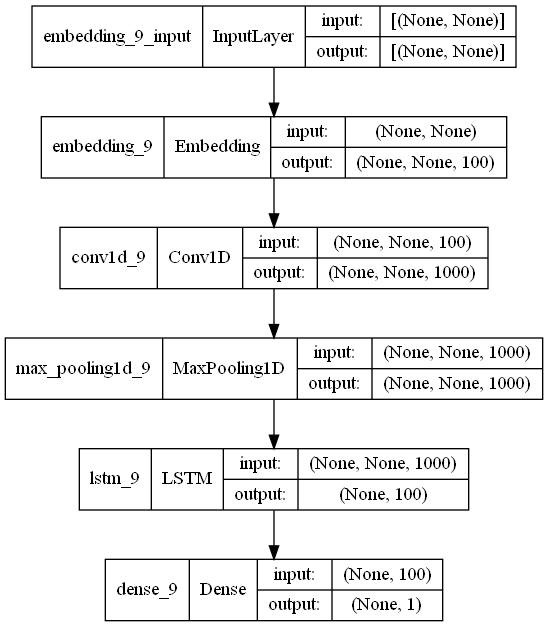

In [288]:
# Vizualizing the Deep Learning Model
plot_model(model, show_shapes = True, show_layer_names = True)

In [289]:
# Fitting the model
start_time = time.time()

model.fit(tokenizer(train_x), train_y, batch_size=100, epochs=5,verbose=1, validation_split = 0.2)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("\nElapsed Time: " + elapsed_time)

Epoch 1/5
228/228 [==============================] - 48s 200ms/step - loss: 0.0000e+00 - accuracy: 0.8329 - val_loss: 0.0000e+00 - val_accuracy: 0.8424
Epoch 2/5
228/228 [==============================] - 42s 185ms/step - loss: 0.0000e+00 - accuracy: 0.8338 - val_loss: 0.0000e+00 - val_accuracy: 0.8424
Epoch 3/5
228/228 [==============================] - 43s 189ms/step - loss: 0.0000e+00 - accuracy: 0.8338 - val_loss: 0.0000e+00 - val_accuracy: 0.8424
Epoch 4/5
228/228 [==============================] - 45s 197ms/step - loss: 0.0000e+00 - accuracy: 0.8338 - val_loss: 0.0000e+00 - val_accuracy: 0.8424
Epoch 5/5
228/228 [==============================] - 45s 196ms/step - loss: 0.0000e+00 - accuracy: 0.8338 - val_loss: 0.0000e+00 - val_accuracy: 0.8424

Elapsed Time: 00:03:43


In [290]:
# Checking the accuracy on test set
accuracy1 = model.evaluate(tokenizer(test_x), test_y)

223/223 [==============================] - 4s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8352
